In [ ]:
import audeer
import audinterface
import audmetric
import audonnx
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm


Load the W2V2 model

In [3]:
model_root = 'model'
cache_root = 'cache'

audeer.mkdir(cache_root)
def cache_path(file):
    return os.path.join(cache_root, file)

url = 'https://zenodo.org/record/6221127/files/w2v2-L-robust-12.6bc4a7fd-1.1.0.zip'
dst_path = cache_path('model.zip')

if not os.path.exists(dst_path):
    audeer.download_url(
        url, 
        dst_path, 
        verbose=True,
    )
    
if not os.path.exists(model_root):
    audeer.extract_archive(
        dst_path, 
        model_root, 
        verbose=True,
    )

In [4]:
model = audonnx.load(model_root)

Load BEST data

In [5]:
berst_test = pd.read_csv("shout-data/test_data.csv")
berst_train = pd.read_csv("shout-data/train_data.csv")
berst_validation = pd.read_csv("shout-data/validation_data.csv")


In [25]:
inference = audinterface.Feature(
    model.labels('logits'),
    process_func=model,
    process_func_args={
        'outputs': 'logits',
    },
    sampling_rate=16000,
    resample=True,    
    verbose=True,
)

In [23]:
test_results_zero_shot_VAD = inference.process_files(berst_test["file_location"])

In [24]:
berst_test_vad_results = berst_test
berst_test_vad_results["arousal"] = list(test_results_zero_shot_VAD["arousal"])
berst_test_vad_results["valence"] = list(test_results_zero_shot_VAD["valence"])
berst_test_vad_results["dominance"] = list(test_results_zero_shot_VAD["dominance"])

Rescale the data

In [26]:
def rescale(value, min_original, max_original):
    return ((value - min_original) / (max_original - min_original)) * (1 - -1) + -1

berst_test_vad_results['arousal'] = berst_test_vad_results['arousal'].apply(lambda x: rescale(x, berst_test_vad_results['arousal'].min(), berst_test_vad_results['arousal'].max(),))
berst_test_vad_results['valence'] = berst_test_vad_results['valence'].apply(lambda x: rescale(x, berst_test_vad_results['valence'].min(), berst_test_vad_results['valence'].max(),))
berst_test_vad_results['dominance'] = berst_test_vad_results['dominance'].apply(lambda x: rescale(x, berst_test_vad_results['dominance'].min(), berst_test_vad_results['dominance'].max(),))

In [25]:
emotion_centroids =  {
    'anger' : [-0.51, 0.59, 0.29],
    'joy' : [0.76, 0.48, 0.35],
    'surprise' : [0.4, 0.67, -0.13],
    'disgust' : [-0.6, 0.35, 0.11],
    'fear' : [-0.64, 0.6, -0.43],
    'sadness' : [-0.63, -0.27, -0.33],
    'neutral' : [0.0, 0.0, 0.0]
}

def find_nearest_centroid(row, centroids):
    distances = []
    emotions = list(centroids.keys())
    for emotion in centroids:
        distance = np.linalg.norm(centroids[emotion] - row)
        distances.append(distance)
    return emotions[np.argmin(distances)]

In [28]:
berst_test_vad_results['zero_shot_emotion'] = berst_test_vad_results[['valence', 'arousal', 'dominance']].apply(lambda row: find_nearest_centroid(np.array(row), emotion_centroids), axis=1)

In [24]:
berst_test_vad_results.to_csv("berst_test_w2v2_zero_shot_results_VAD.csv", index=False)

In [30]:
print(f"UA score: {accuracy_score(berst_test_vad_results['affect'], berst_test_vad_results['zero_shot_emotion'])}")
print(f"WA score: {balanced_accuracy_score(berst_test_vad_results['affect'], berst_test_vad_results['zero_shot_emotion'])}")

UA score: 0.231203007518797
WA score: 0.21098257225729444


In [81]:
def plot_predictions(data, features, predictions):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')


    emotions = data['affect'].unique()
    print(emotions)
    colors = plt.cm.get_cmap('tab10', len(emotions))

    for i, emotion in enumerate(emotions):
        subset = data[data[predictions] == emotion]
        ax.scatter(subset[features].iloc[:,0], subset[features].iloc[:,1], subset[features].iloc[:,2], c=colors(i), label=emotion)

    ax.set_xlabel('Valence')
    ax.set_ylabel('Arousal')
    ax.set_zlabel('Dominance')
    ax.legend()

    plt.title('VAD plot by emotion class')
    plt.show()

In [3]:
berst_test_vad_results = pd.read_csv("/home/rosie/Documents/BERST/audeering/berst_test_w2v2_zero_shot_results_VAD.csv")

/tmp/ipykernel_8326/796469188.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(emotions))
/tmp/ipykernel_8326/796469188.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(subset[features].iloc[:,0], subset[features].iloc[:,1], subset[features].iloc[:,2], c=colors(i), label=emotion)
/tmp/ipykernel_8326/796469188.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches wi

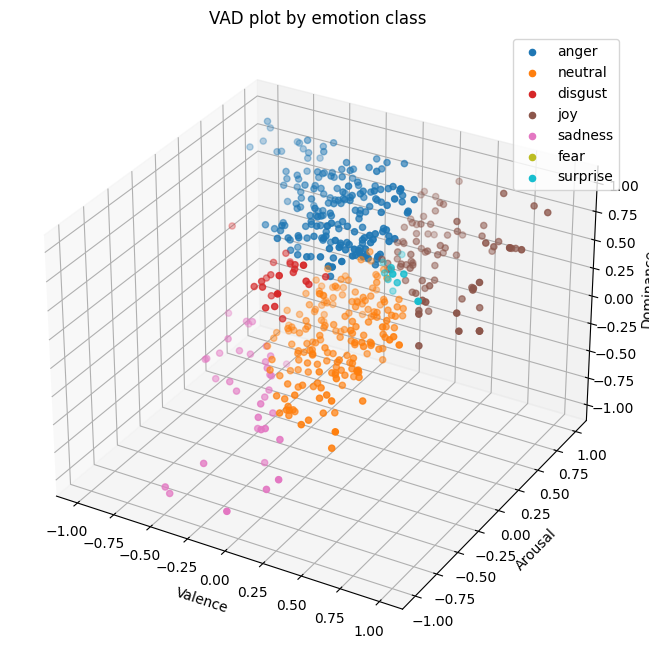

In [6]:
plot_predictions(berst_test_vad_results, ['valence', 'arousal', 'dominance'], 'zero_shot_emotion')

/tmp/ipykernel_8326/796469188.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(emotions))
/tmp/ipykernel_8326/796469188.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(subset[features].iloc[:,0], subset[features].iloc[:,1], subset[features].iloc[:,2], c=colors(i), label=emotion)
/tmp/ipykernel_8326/796469188.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches wi

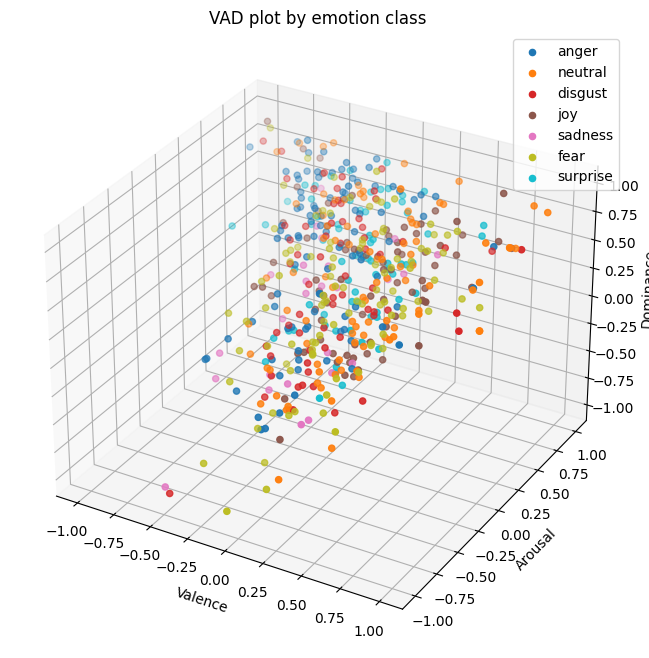

In [7]:
plot_predictions(berst_test_vad_results, ['valence', 'arousal', 'dominance'], 'affect')

Same for IEMOCAP

usually trained on leave one session out, so average over the sessions

In [21]:
iemocap = pd.read_csv("/home/rosie/Documents/BERST/audeering/IEMOCAP_full_release/labels/session_1_labels.csv")

In [22]:
iemocap = iemocap[iemocap['affect'].isin(['Happiness', 'Sadness', 'Neutral', 'Anger'])]

In [27]:
iemocap_results_zero_shot_VAD = inference.process_files(iemocap["file_location"])

In [57]:
emotion_centroids =  {
    'Anger' : [-0.51, 0.59, 0.29],
    'Happiness' : [0.76, 0.48, 0.35],
    'Surprise' : [0.4, 0.67, -0.13],
    'Disgust' : [-0.6, 0.35, 0.11],
    'Fear' : [-0.64, 0.6, -0.43],
    'Sadness' : [-0.63, -0.27, -0.33],
    'Neutral' : [0.0, 0.0, 0.0]
}

In [58]:
iemocap["arousal"] = list(iemocap_results_zero_shot_VAD["arousal"])
iemocap["valence"] = list(iemocap_results_zero_shot_VAD["valence"])
iemocap["dominance"] = list(iemocap_results_zero_shot_VAD["dominance"])

In [59]:
def rescale(value, min_original, max_original):
    return ((value - min_original) / (max_original - min_original)) * (1 - -1) + -1

iemocap['arousal'] = iemocap['arousal'].apply(lambda x: rescale(x, iemocap['arousal'].min(), iemocap['arousal'].max(),))
iemocap['valence'] = iemocap['valence'].apply(lambda x: rescale(x, iemocap['valence'].min(), iemocap['valence'].max(),))
iemocap['dominance'] = iemocap['dominance'].apply(lambda x: rescale(x, iemocap['dominance'].min(), iemocap['dominance'].max(),))

In [60]:
iemocap['zero_shot_emotion'] = iemocap[['valence', 'arousal', 'dominance']].apply(lambda row: find_nearest_centroid(np.array(row), emotion_centroids), axis=1)
print(f"UA score: {accuracy_score(iemocap['affect'], iemocap['zero_shot_emotion'])}")
print(f"WA score: {balanced_accuracy_score(iemocap['affect'], iemocap['zero_shot_emotion'])}")

UA score: 0.43296762108643294
WA score: 0.2723913690972883


In [62]:
iemocap.to_csv("iemocap_results_VAD_5.csv", index=False)

In [8]:
iemocap = pd.read_csv("/home/rosie/Documents/BERST/audeering/iemocap_results_VAD_1.csv")

['Sadness' 'Surprise' 'Anger' 'Neutral' 'Disgust' 'Happiness' 'Fear']


/tmp/ipykernel_8326/794982126.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(emotions))
/tmp/ipykernel_8326/794982126.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(subset[features].iloc[:,0], subset[features].iloc[:,1], subset[features].iloc[:,2], c=colors(i), label=emotion)
/tmp/ipykernel_8326/794982126.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches wi

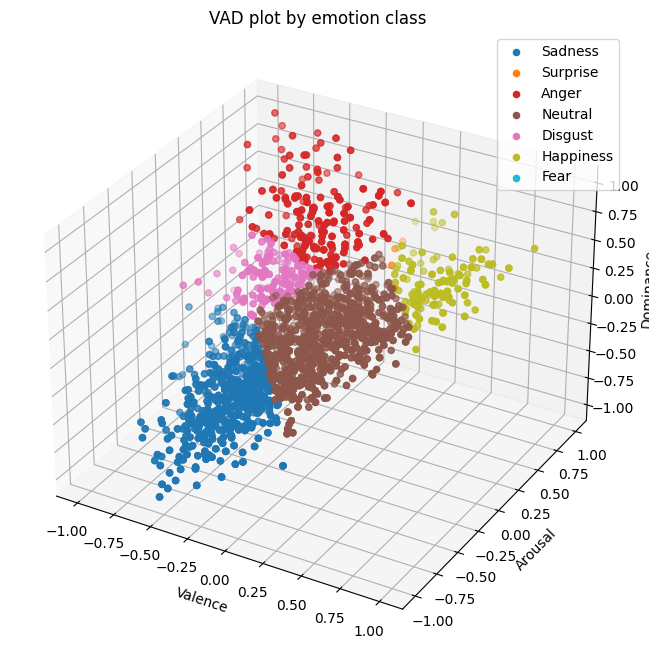

In [35]:
plot_predictions(iemocap, ['valence', 'arousal', 'dominance'], 'zero_shot_emotion')

['Sadness' 'Surprise' 'Anger' 'Neutral' 'Disgust' 'Happiness' 'Fear']


/tmp/ipykernel_8326/794982126.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(emotions))
/tmp/ipykernel_8326/794982126.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(subset[features].iloc[:,0], subset[features].iloc[:,1], subset[features].iloc[:,2], c=colors(i), label=emotion)
/tmp/ipykernel_8326/794982126.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches wi

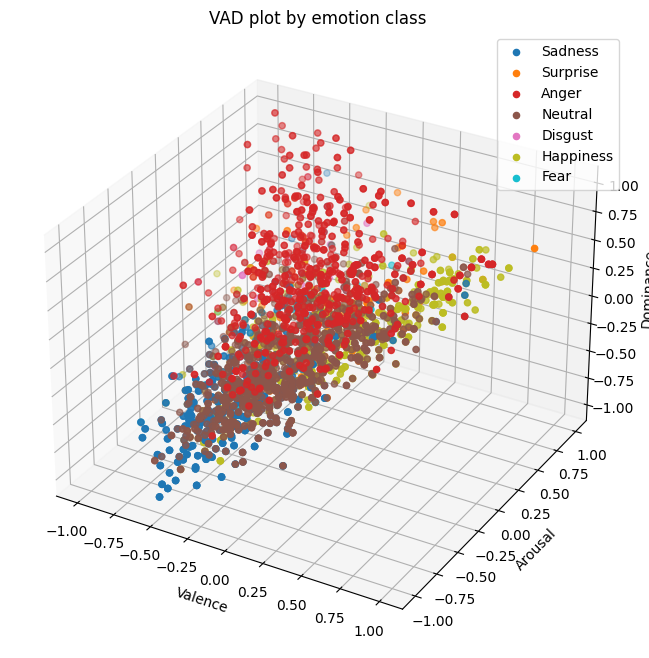

In [36]:
plot_predictions(iemocap, ['valence', 'arousal', 'dominance'], 'affect')

In [ ]:
cf_matrix = confusion_matrix(y, y_pred)
print(cf_matrix)

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

# Fine tune with an SVM

In [40]:
hidden_states = audinterface.Feature(
    model.labels('hidden_states'),
    process_func=model,
    process_func_args={
        'outputs': 'hidden_states',
    },
    sampling_rate=16000,    
    resample=True,    
    num_workers=5,
    verbose=True,
)


In [3]:
features_w2v2_train = hidden_states.process_files(berst_train["file_location"])
features_w2v2_train.to_csv("berst_train_w2v2_hidden_zero_shot.csv", index=False)

NameError: name 'hidden_states' is not defined

In [13]:
features_w2v2_test = hidden_states.process_files(berst_test["file_location"])
features_w2v2_test.to_csv("berst_test_w2v2_hidden_zero_shot.csv", index=False)

NameError: name 'hidden_states' is not defined

In [27]:
features_w2v2_validation = hidden_states.process_files(berst_validation["file_location"])
features_w2v2_validation.to_csv("berst_validation_w2v2_hidden_zero_shot.csv", index=False)

In [11]:
features_w2v2_validation = pd.read_csv('berst_validation_w2v2_hidden_zero_shot.csv')
features_w2v2_train = pd.read_csv('berst_train_w2v2_hidden_zero_shot.csv')
features_w2v2_test = pd.read_csv('berst_test_w2v2_hidden_zero_shot.csv')

In [12]:
def svm_fine_tune_search(
    train_features,
    train_targets,
    test_features,
    test_targets
):
    param_grid = {'C': [10, 100, 1000, 10000, 100000],
              'gamma': [100, 10, 0.1, 0.01, 0.001, 0.0001, 0.00001],
              'kernel': ['rbf']}

    max_WA= {'C': 0.1, 'gamma': 1, 'kernel': 'rbf', 'WA': 0}
    max_UA = {'C': 0.1, 'gamma': 1, 'kernel': 'rbf', 'UA': 0}

    for c in tqdm(param_grid['C']):
        for gamma in tqdm(param_grid['gamma']):
            for kernel in tqdm(param_grid['kernel']):
                clf = make_pipeline(
                    StandardScaler(), 
                    SVC(gamma=gamma, kernel=kernel, C = c),
                )
                clf.fit(train_features, train_targets)
                predict_y = clf.predict(test_features)

                WA = balanced_accuracy_score(test_targets, predict_y)
                if WA > max_WA['WA']:
                    max_WA['C'] = c
                    max_WA['gamma'] = gamma
                    max_WA['kernel'] = kernel
                    max_WA['WA'] = WA
                UA = accuracy_score(test_targets, predict_y)
                if UA > max_UA['UA']:
                    max_UA['C'] = c
                    max_UA['gamma'] = gamma
                    max_UA['kernel'] = kernel
                    max_UA['UA'] = UA


    return(max_UA, max_WA)

def svm_fine_tune_test(
    train_features,
    train_targets,
    test_features,
    test_targets,
    gamma,
    kernel,
    c
):
    clf = make_pipeline(
        StandardScaler(), 
        SVC(gamma=gamma, kernel=kernel, C = c),
    )
    clf.fit(train_features, train_targets)
    predict_y = clf.predict(test_features)

    print(f'WA score: {balanced_accuracy_score(test_targets, predict_y)}')
    print(f"UA score: {accuracy_score(test_targets, predict_y)}")

    return predict_y



In [13]:
ground_truth_train = berst_train['affect']
ground_truth_validation = berst_validation['affect']


max_accuracy, max_f1, max_recall = svm_fine_tune_search(features_w2v2_train, ground_truth_train, features_w2v2_validation, ground_truth_validation)

  0%|          | 0/5 [00:00<?, ?it/s]


  0%|          | 0/5 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [9]:
print(max_accuracy)
print(max_f1)
print(max_recall)

{'C': 1000, 'gamma': 1e-06, 'kernel': 'rbf', 'accuracy': 0.30327868852459017}
{'C': 1000, 'gamma': 1e-06, 'kernel': 'rbf', 'f1': 0.2997652880918811}
{'C': 1000, 'gamma': 1e-06, 'kernel': 'rbf', 'recall': 0.28089218336917254}


In [14]:
ground_truth_test = berst_test['affect']

svm_predictions = svm_fine_tune_test(features_w2v2_train, ground_truth_train, features_w2v2_test, ground_truth_test, 0.001, 'rbf', 100)
berst_test['svm_predictions'] = svm_predictions

WA score: 0.302441376206877
UA score: 0.29887218045112784


In [22]:
berst_test.to_csv('berst_test_w2v2_svm_fine_tune_results.csv', index=False)

In [27]:
tsne = TSNE(n_components=3, random_state=0)
projections = pd.DataFrame(tsne.fit_transform(features_w2v2_test, ))

In [28]:
berst_test['tsne1'] = projections.iloc[:,0]
berst_test['tsne2'] = projections.iloc[:,1]
berst_test['tsne3'] = projections.iloc[:,2]

/tmp/ipykernel_4912/796469188.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(emotions))
/tmp/ipykernel_4912/796469188.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(subset[features].iloc[:,0], subset[features].iloc[:,1], subset[features].iloc[:,2], c=colors(i), label=emotion)
/tmp/ipykernel_4912/796469188.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches wi

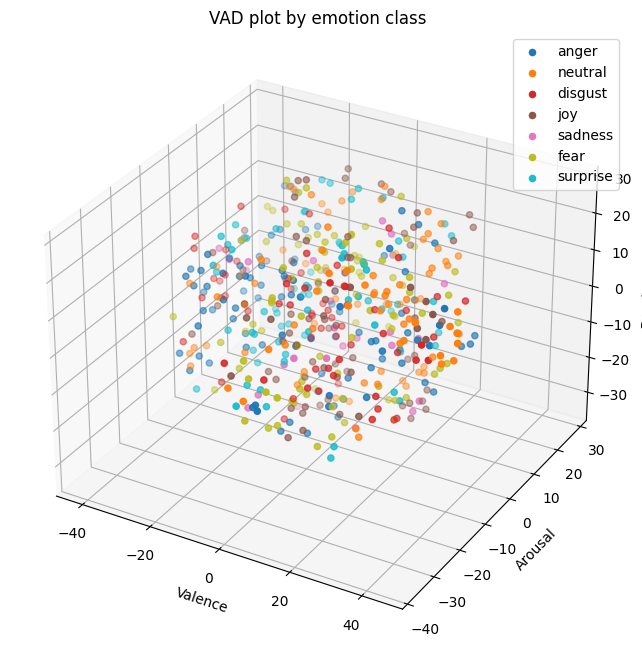

In [29]:
plot_predictions(berst_test, ['tsne1', 'tsne2', 'tsne3'], 'affect')

/tmp/ipykernel_4912/796469188.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(emotions))
/tmp/ipykernel_4912/796469188.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(subset[features].iloc[:,0], subset[features].iloc[:,1], subset[features].iloc[:,2], c=colors(i), label=emotion)
/tmp/ipykernel_4912/796469188.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches wi

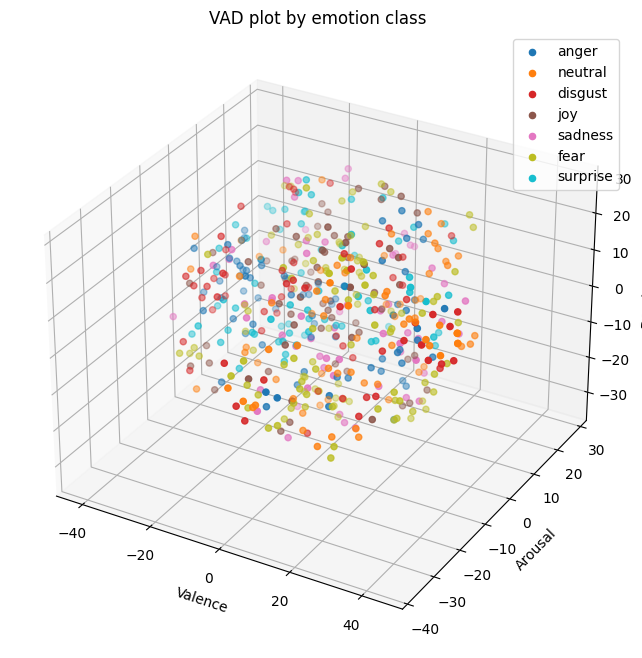

In [31]:
plot_predictions(berst_test, ['tsne1', 'tsne2', 'tsne3'], 'svm_predictions')

In [33]:
berst_test_vad_results = pd.read_csv("berst_test_w2v2_zero_shot_results_VAD.csv")
berst_test_vad_results['svm_predictions'] = svm_predictions

In [1]:
plot_predictions(berst_test_vad_results, ['valence', 'arousal', 'dominance'], 'svm_predictions')

NameError: name 'plot_predictions' is not defined

# SVM Iemocap

In [53]:
features_w2v2_iemocap = hidden_states.process_files(iemocap["file_location"])
features_w2v2_iemocap.to_csv("iemocap_5_w2v2_hidden_zero_shot.csv", index=False)

In [15]:
iemocap_hidden_1 = pd.read_csv('iemocap_1_w2v2_hidden_zero_shot.csv')
iemocap_hidden_2 = pd.read_csv('iemocap_2_w2v2_hidden_zero_shot.csv')
iemocap_hidden_3 = pd.read_csv('iemocap_3_w2v2_hidden_zero_shot.csv')
iemocap_hidden_4 = pd.read_csv('iemocap_4_w2v2_hidden_zero_shot.csv')
iemocap_hidden_5 = pd.read_csv('iemocap_5_w2v2_hidden_zero_shot.csv')

iemocap_hidden_list = [iemocap_hidden_1, iemocap_hidden_2, iemocap_hidden_3, iemocap_hidden_4, iemocap_hidden_5]

iemocap_1 = pd.read_csv('IEMOCAP_full_release/labels/session_1_labels.csv')
iemocap_2 = pd.read_csv('IEMOCAP_full_release/labels/session_2_labels.csv')
iemocap_3 = pd.read_csv('IEMOCAP_full_release/labels/session_3_labels.csv')
iemocap_4 = pd.read_csv('IEMOCAP_full_release/labels/session_4_labels.csv')
iemocap_5 = pd.read_csv('IEMOCAP_full_release/labels/session_5_labels.csv')

iemocap_1 = iemocap_1[iemocap_1['affect'].isin(['Happiness', 'Sadness', 'Surprise', 'Neutral', 'Disgust', 'Anger', 'Fear'])]
iemocap_2 = iemocap_2[iemocap_2['affect'].isin(['Happiness', 'Sadness', 'Surprise', 'Neutral', 'Disgust', 'Anger', 'Fear'])]
iemocap_3 = iemocap_3[iemocap_3['affect'].isin(['Happiness', 'Sadness', 'Surprise', 'Neutral', 'Disgust', 'Anger', 'Fear'])]
iemocap_4 = iemocap_4[iemocap_4['affect'].isin(['Happiness', 'Sadness', 'Surprise', 'Neutral', 'Disgust', 'Anger', 'Fear'])]
iemocap_5 = iemocap_5[iemocap_5['affect'].isin(['Happiness', 'Sadness', 'Surprise', 'Neutral', 'Disgust', 'Anger', 'Fear'])]

iemocap_list = [iemocap_1, iemocap_2, iemocap_3, iemocap_4, iemocap_5]

In [13]:
results = []
for i,session in enumerate(iemocap_list):
    if i == 0:
      training_set = iemocap_hidden_list[:]
      del training_set[i]
      combined_sessions = pd.concat(training_set)

      training_labels = iemocap_list[:]
      del training_labels[i]
      combined_labels = pd.concat(training_labels)

      ground_truth_train = combined_labels['affect']
      ground_truth_validation = session['affect']

      results.append(svm_fine_tune_search(combined_sessions, ground_truth_train, iemocap_hidden_list[i], ground_truth_validation))

NameError: name 'iemocap_list' is not defined

In [7]:
results

[({'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'accuracy': 0.6170814479638009},
  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'f1': 0.6043463132098614},
  {'C': 10000,
   'gamma': 1e-06,
   'kernel': 'rbf',
   'recall': 0.43050538785112075})]

In [11]:
for i,session in enumerate(iemocap_list):
    training_set = iemocap_hidden_list[:]
    del training_set[i]
    combined_sessions = pd.concat(training_set)

    training_labels = iemocap_list[:]
    del training_labels[i]
    combined_labels = pd.concat(training_labels)

    ground_truth_train = combined_labels['affect']
    ground_truth_validation = session['affect']

    session['svm_predictions'] = svm_fine_tune_test(combined_sessions, ground_truth_train, iemocap_hidden_list[i], ground_truth_validation, 0.001, 'rbf', 100)

WA score: 0.41378374393490464
UA score: 0.6170814479638009
WA score: 0.45277602791292654
UA score: 0.6743282615733247
WA score: 0.41326392077951785
UA score: 0.6111252870630263
WA score: 0.4186740060622228
UA score: 0.640601947477132
WA score: 0.38557809522440634
UA score: 0.6007492641156007


In [16]:
for i,session in enumerate(iemocap_list):
    training_set = iemocap_hidden_list[:]
    del training_set[i]
    combined_sessions = pd.concat(training_set)

    training_labels = iemocap_list[:]
    del training_labels[i]
    combined_labels = pd.concat(training_labels)

    ground_truth_train = combined_labels['affect']
    ground_truth_validation = session['affect']

    session['svm_predictions'] = svm_fine_tune_test(combined_sessions, ground_truth_train, iemocap_hidden_list[i], ground_truth_validation, 0.000001, 'rbf', 1000)

WA score: 0.40513097772863677
UA score: 0.6035067873303167
WA score: 0.4142222192587182
UA score: 0.6497248300420848
WA score: 0.38502487021163445
UA score: 0.5924980862464915
WA score: 0.3859304616513078
UA score: 0.6382413691354382
WA score: 0.36118805320706576
UA score: 0.586031576130586


## SVM on vad results

### IEMOCAP

In [6]:
iemocap_1_vad = pd.read_csv('iemocap_results_VAD_1.csv')
iemocap_2_vad = pd.read_csv('iemocap_results_VAD_2.csv')
iemocap_3_vad = pd.read_csv('iemocap_results_VAD_3.csv')
iemocap_4_vad = pd.read_csv('iemocap_results_VAD_4.csv')
iemocap_5_vad = pd.read_csv('iemocap_results_VAD_5.csv')

iemocap_vad_list = [iemocap_1_vad, iemocap_2_vad, iemocap_3_vad, iemocap_4_vad, iemocap_5_vad]

In [14]:
results = []
for i,session in enumerate(iemocap_vad_list):
    if i == 1:
      training_set = iemocap_vad_list[:]
      del training_set[i]
      combined_sessions = pd.concat(training_set)
      combined_sessions_features = combined_sessions.drop(["affect", "file_location", "zero_shot_emotion"], axis = 1)
      session_features = session.drop(["affect", "file_location", "zero_shot_emotion"], axis = 1)

      ground_truth_train = combined_sessions['affect']
      ground_truth_validation = session['affect']

      results.append(svm_fine_tune_search(combined_sessions_features, ground_truth_train, session_features, ground_truth_validation))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


 20%|██        | 1/5 [00:42<02:51, 42.81s/it]

100%|██████████| 1/1 [00:11<00:00, 11.09s/it]


100%|██████████| 1/1 [00:25<00:00, 25.17s/it]


100%|██████████| 1/1 [00:26<00:00, 26.61s/it]


100%|██████████| 1/1 [00:06<00:00,  6.96s/it]


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


100%|██████████| 1/1 [00:04<00:00,  4.10s/it]


 40%|████      | 2/5 [02:04<03:17, 65.69s/it]

100%|██████████| 1/1 [00:11<00:00, 11.24s/it]


100%|██████████| 1/1 [02:11<00:00, 131.39s/it]


100%|██████████| 1/1 [01:50<00:00, 110.78s/it]


100%|██████████| 1/1 [00:34<00:00, 34.86s/it]


100%|██████████| 1/1 [00:11<00:00, 11.04s/it]


100%|██████████| 1/1 [00:05<00:00,  5.07s/it]


 

In [15]:
results

[({'C': 100000, 'gamma': 0.01, 'kernel': 'rbf', 'UA': 0.5393331175137585},
  {'C': 10, 'gamma': 10, 'kernel': 'rbf', 'WA': 0.29297375510673956})]

In [16]:
for i,session in enumerate(iemocap_vad_list):
    training_set = iemocap_vad_list[:]
    del training_set[i]
    combined_sessions = pd.concat(training_set)
    combined_sessions_features = combined_sessions.drop(["affect", "file_location", "zero_shot_emotion"], axis = 1)
    session_features = session.drop(["affect", "file_location", "zero_shot_emotion"], axis = 1)

    ground_truth_train = combined_sessions['affect']
    ground_truth_validation = session['affect']

    svm_predictions = svm_fine_tune_test(combined_sessions_features, ground_truth_train, session_features, ground_truth_validation, 10, 'rbf', 10)

WA score: 0.28444952979318855
UA score: 0.5028280542986425
WA score: 0.29297375510673956
UA score: 0.5228229200388476
WA score: 0.25326824096601547
UA score: 0.46823169175810153
WA score: 0.28072372639675247
UA score: 0.5219828858070227
WA score: 0.2732724286752256
UA score: 0.48541610917848543


### BERSt

In [17]:
berst_vad_results_train = pd.read_csv('berst_train_w2v2_zero_shot_results_VAD.csv')
berst_vad_results_validation = pd.read_csv('berst_validate_w2v2_zero_shot_results_VAD.csv')
berst_vad_results_test = pd.read_csv('berst_test_w2v2_zero_shot_results_VAD.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'berst_train_w2v2_zero_shot_results_VAD.csv'

In [ ]:
ground_truth_train = berst_vad_results_train['affect']
features_train = berst_vad_results_train.drop(["affect", "file_location", "zero_shot_emotion"], axis = 1)


ground_truth_validation = berst_vad_results_validation['affect']
features_validation = berst_vad_results_validation.drop(["affect", "file_location", "zero_shot_emotion"], axis = 1)


max_accuracy, max_f1, max_recall = svm_fine_tune_search(features_train, ground_truth_train, features_validation, ground_truth_validation)

In [ ]:
ground_truth_test = berst_vad_results_test['affect']
features_test = berst_vad_results_test.drop(["affect", "file_location", "zero_shot_emotion"], axis = 1)

svm_predictions = svm_fine_tune_test(features_train, ground_truth_train, features_test, ground_truth_test, 0.001, 'rbf', 100)